# Содержание 

- [Text summarization](#ch1)
    - [Описание набора данных](#ch2)
    - [Extractive methods](#ch3)
        - [Word frequency method](#ch4)
        - [TextRank](#ch5)
        - [ClusterRank](#ch6)
        - [LSA](#ch7)
        - [KLSum](#ch8)
        - [MEAD](#ch9)
    - [Abstractive methods](#ch10)
        - [BERT](#ch11)
        - [GPT-2](#ch12)
        - [XLNet](#ch13)
        - [T5 with fine-tuning](#ch14)
- [Speech Recognition](#ch15)
    - [Обработка звука](#ch16)
    - [Google speech to text](#ch17)
    - [wav2vec](#ch18)
    - [IBM Watson](#ch19)
    - [Метрики распознавания речи](#ch20)
- [Комбинация алгоритма распознавания речи и суммаризации](#ch21)

# Суммаризация текста  <a class="anchor" id="ch1"></a>

## Описание набора данных  + сохранение файлов в отдельные csv <a class="anchor" id="ch2"></a>

В качестве данных для верификации моделей возьмем AMI Meeting Corpus, содержащий 100 часов звукозаписей, транскрипты, разделенные по говорящим и рефераты к ним - экстрактивный и абстрактивный. Примерно треть данных состоит из искусственно составленных сценариев совещаний от команды дизайнеров, а остальная часть - реально проходящие в деловом центре переговоры.

Пример текстового файла: ES2002a.transcript.txt, первые две буквы это страна, в котором записывалось данное совещание, одно совещание состоит из 4 частей: a, b, c и d.  

In [ ]:
test = open('ami-transcripts/ES2002a.transcript.txt', "r", errors = 'ignore')
transcript = test.read()

In [100]:
# transcript

In [ ]:
test2 = open('extractive/ES2002a.extsumm.txt', "r", errors = 'ignore')
transcript_sum = test2.read()

In [101]:
# transcript_sum

In [ ]:
print('The length of the transription: {}'.format(len(transcript)))
print('The length of the summary of the transcription: {}'.format(len(transcript_sum)))

The length of the transription: 13676
The length of the summary of the transcription: 4318


Создадим 2 отдельных датасета для extractive методов и abstarctive методов с соотвественными им аудиофайлами. В датасете будет содержаться название файлов. 

In [102]:
import os
folder_ext = 'extractive'
ext = [x[2] for x in os.walk(folder_ext)][0]
ext_summaries_files = []
for i in ext:
     ext_summaries_files.append('extractive/' + i)


In [103]:
folder_transc = 'ami-transcripts'
fol_trans = [x[2] for x in os.walk(folder_transc)]
ext_sum_trans = []
for i in ext:
    ext_sum_trans.append('ami-transcripts/' + i[ : i.find(".")] + '.transcript.txt' )
#ext_sum_trans

In [104]:
folder_abs = 'abstractive'
abs_ = [x[2] for x in os.walk(folder_abs)]
abs_summaries_files = []
for i in abs_[0]:
    abs_summaries_files.append('abstractive/' + i)
#abs_summaries_files

In [105]:
folder_transc = 'ami-transcripts'
fol_trans = [x[2] for x in os.walk(folder_transc)]
abs_sum_trans = []
for i in abs_[0]:
    abs_sum_trans.append('ami-transcripts/' + i[ : i.find(".")] + '.transcript.txt' )
#abs_sum_trans

Составим датафрейм с 2 столбцами: текст и реферат к нему 

In [2]:
# extractive
# summaries
import pandas as pd
summaries_extractive = []
for i in ext_summaries_files:
    test1 = open(i, "r", errors = 'ignore')
    transcript1 = test1.read()
    summaries_extractive.append(transcript1)
# texts
text_extractive = []
for j in ext_sum_trans:
    test2 = open(j, "r", errors = 'ignore')
    transcript2 = test2.read()
    text_extractive.append(transcript2)
df_extractive = pd.DataFrame({'extractive_text': text_extractive, 'extractive_summary': summaries_extractive})
df_extractive.head()

In [ ]:
df_extractive.to_csv('extractive_dataset.csv')

In [ ]:
# extractive
# summaries
import pandas as pd
summaries_extractive = []
for i in abs_summaries_files:
    test1 = open(i, "r", errors = 'ignore')
    transcript1 = test1.read()
    summaries_extractive.append(transcript1)
# texts
text_extractive = []
for j in abs_sum_trans:
    test2 = open(j, "r", errors = 'ignore')
    transcript2 = test2.read()
    text_extractive.append(transcript2)
df_abstractive = pd.DataFrame({'abstractive_text': text_extractive, 'abstarctive_summary': summaries_extractive})
df_abstractive.head()

,abstractive_text,abstarctive_summary
0,Okay okay Okay. Hello. Okay. My name's Poppy. ...,The project manager opens the meeting by intro...
1,"Good morning. Sorry? Yeah, busy job. Good morn...",The project manager acquainted the team with t...
2,"Alright, yeah. crack on. Okay so we'll start o...",The project manager recapped the decisions mad...
3,Right w welcome to the the first meeting of uh...,The project manager opens the meeting by welco...
4,Oops. Mm. After lunch. Yeah. Mm-hmm. Mm-hmm. '...,The Project Manager reviewed the decisions fro...


In [ ]:
df_abstractive.to_csv('abstractive_dataset.csv')

## Обработка текста 

In [27]:
# !pip install -U gensim

In [30]:
# !pip install spacy

In [32]:
# libraries
import re, numpy as np, pandas as pd
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
stopwords_english = stopwords.words('english')
stopwords_english.append('um')
stopwords_english.append('Hmm')
stopwords_english.append('Um')
stopwords_english.append('okay')
stopwords_english.append('uh')
stopwords_english.append('Yeah')
stopwords_english.append('yeah')
stopwords_english.append('Mm')
stopwords_english.append('well')
stopwords_english.append('Well')
stopwords_english.append('hmm')
stopwords_english.append('weve')
stopwords_english.append('ive')
stopwords_english.append('yep')
stopwords_english.append('alright')
stopwords_english.append('Alright')
stopwords_english.append('mm')
stopwords_english.append('kay')
stopwords_english.append('gosh')
stopwords_english.append('like')
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
# убираем знак новой строки 
a2 = transcript.replace("\n", "")
a = a2.replace("\ ", " ")
#a

In [ ]:
# убираем знаки препинания из текста 
text =[]
split_regex = re.compile(r'[.|!|?|…]')
sentences = filter(lambda t: t, [t.strip() for t in split_regex.split(a)])
for s in sentences:
    text.append(s)

In [107]:
# text

In [22]:
# убираем ненужные символы и делим предложение на слова
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [108]:
res = list(sent_to_words(text))
#res

In [ ]:
# убираем стоп-слова
res_ = []
s_ =[]
for s in res:
    for word in s:
        if word not in stopwords_english:
            s_.append(word)
    res_.append(s_)
    s_ = []

In [109]:
#res_

In [34]:
# лемматизация 
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
res_fin = []
s_fin = []
for s in res_:
    for word in s:
        s_fin.append(lemmatizer.lemmatize(word))
    # проверка на пустой список 
    if s_fin != []:
        res_fin.append(s_fin)
    s_fin = []

In [110]:
res_fin

In [ ]:
# функция, которая объединяет все выше сделанные действия  
def preprocess(filename):
    f = open(filename, "r") 
    a = f.read()
    text =[]
    split_regex = re.compile(r'[.|!|?|…]')
    sentences = filter(lambda t: t, [t.strip() for t in split_regex.split(a)])
    for s in sentences:
        text.append(s)
    res = list(sent_to_words(text))
    res_ = []
    s_ =[]
    for s in res:
        for word in s:
            if word not in stopwords_english:
                s_.append(word)
        res_.append(s_)
        s_ = []
    res_fin = []
    s_fin = []
    for s in res_:
        for word in s:
            s_fin.append(lemmatizer.lemmatize(word))
        if s_fin != []:
            res_fin.append(s_fin)
        s_fin = []
    return res_fin

In [ ]:
!pip install rouge

In [ ]:
# загружаем нужные нам библиотеки 
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
punctuation += '\n'
from heapq import nlargest
from nltk.cluster.util import cosine_distance
import networkx as nx
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
from collections import Counter

## Extractive methods <a class="anchor" id="ch3"></a>

### Word frequency method  <a class="anchor" id="ch4"></a>

Рассмотрим алгоритм на примере одного файла. 

In [ ]:
import pandas as pd
df_extractive = pd.read_csv('/content/extractive_dataset.csv')
df_extractive

,Unnamed: 0,extractive_text,extractive_summary
0,0,"Wouldn't wanna be Project Manager. Uh, what we...","Um , once again I'm uh gonna take minutes . Uh..."
1,1,Me too. Okay. Um here's the agenda for our las...,Okay . Um here's the agenda for our last meeti...
2,2,Oops. That's as far as it goes. Do you also do...,uh good morning everybody here . And uh I want...
3,3,"Hmm. E excuse me I forgot my copy. No, not min...","Uh oh I've forgotten to mail you the minutes ,..."
4,4,"Okay, can I have the laptop over here, or? Oka...",Tod uh for this meeting I will take the notes ...
...,...,...,...
132,132,"Morning. Yep. My name's Frank. Thank you. Hmm,...","First I will introduce myself . I'm Bart , My ..."
133,133,"No. We should make a big sponge lemon, and the...",mailed you the minutes of the last meeting uh ...
134,134,Mm-hmm. Yeah. I'm Robin. I'm the Marketing Man...,Right Where we uh We have twenty five minutes ...
135,135,Hello. Hello. You have to put it exactly on th...,Hello you all read what we are going to do or ...


In [ ]:
a = open('ami-transcripts/EN2001a.transcript.txt', "r", errors = 'ignore')
transcript_sum = a.read()

In [114]:
#transcript_sum

In [111]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(transcript_sum)
tokens = [token.text for token in doc]
#tokens

In [ ]:
word_freq = {}
for word in doc:
    if word.text.lower() not in stopwords_english:
        if word.text.lower() not in punctuation:
            if word.text not in word_freq.keys():
                word_freq[word.text] = 1
            else:
                word_freq[word.text] += 1

In [112]:
print(word_freq)

In [ ]:
max_freq = max(word_freq.values())
for word in word_freq.keys():
    word_freq[word] = word_freq[word]/max_freq

In [ ]:
sentence_tokens = [sent for sent in doc.sents]

In [113]:
#sentence_tokens

In [ ]:
sentence_scores = {}
for sent in sentence_tokens:
    for word in sent:
        if word.text.lower() in word_freq.keys():
            if sent not in sentence_scores.keys():
                sentence_scores[sent] = word_freq[word.text.lower()]
            else:
                sentence_scores[sent] += word_freq[word.text.lower()]

In [115]:
#print(sentence_scores)

In [ ]:
select_length = int(len(sentence_tokens) * 0.05)

In [116]:
summary = nlargest(select_length, sentence_scores, key = sentence_scores.get)
#summary

In [117]:
summary_luhn =[]
for i in summary:
    summary_luhn.append(str(i))
final_luhn = ' '.join(summary_luhn)
#final_luhn 

In [40]:
# соберем все в одну функцию 
from string import punctuation
from heapq import nlargest
def summary_luhn(transcript_sum):
    stopwords = stopwords_english
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(transcript_sum)
    tokens = [token.text for token in doc]
    word_freq = {}
    for word in doc:
        if word.text.lower() not in stopwords_english:
            if word.text.lower() not in punctuation:
                if word.text not in word_freq.keys():
                    word_freq[word.text] = 1
                else:
                    word_freq[word.text] += 1
    max_freq = max(word_freq.values())
    for word in word_freq.keys():
        word_freq[word] = word_freq[word]/max_freq
    sentence_tokens = [sent for sent in doc.sents]
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_freq.keys():
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_freq[word.text.lower()]
                else:
                    sentence_scores[sent] += word_freq[word.text.lower()]
    select_length = int(len(sentence_tokens) * 0.05)
    summary = nlargest(select_length, sentence_scores, key = sentence_scores.get)
    summary_luhn =[]
    for i in summary:
        summary_luhn.append(str(i))
    final_luhn = ' '.join(summary_luhn)
    return final_luhn 


In [ ]:
df_extractive.head()

,Unnamed: 0,extractive_text,extractive_summary
0,0,"Wouldn't wanna be Project Manager. Uh, what we...","Um , once again I'm uh gonna take minutes . Uh..."
1,1,Me too. Okay. Um here's the agenda for our las...,Okay . Um here's the agenda for our last meeti...
2,2,Oops. That's as far as it goes. Do you also do...,uh good morning everybody here . And uh I want...
3,3,"Hmm. E excuse me I forgot my copy. No, not min...","Uh oh I've forgotten to mail you the minutes ,..."
4,4,"Okay, can I have the laptop over here, or? Oka...",Tod uh for this meeting I will take the notes ...


In [ ]:
final_luhn = summary_luhn(df_extractive['extractive_text'][0])

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(final_luhn, df_extractive['extractive_summary'][0])
print('Luhn scores: {}'.format(scores))

Luhn scores: [{'rouge-1': {'f': 0.41947565150169724, 'p': 0.7808764940239044, 'r': 0.2867593269934162}, 'rouge-2': {'f': 0.23286937508712185, 'p': 0.4336989032901296, 'r': 0.15916575192096596}, 'rouge-l': {'f': 0.48659383849881027, 'p': 0.6786703601108033, 'r': 0.37925696594427244}}]


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
import numpy as np 
def preprocess_text_simple(text):
    # 0>
    text = text.lower()
    # 1
    tokens = word_tokenize(text)
    # 2 и 3 
    tokens = [token for token in tokens if token not in stopwords_english
              and token.isalpha()
              and token.strip() not in punctuation
              #and token.strip() not in numbers
             ]
    # 4
    return tokens

In [ ]:
scores1f = []
scores1p = []
scores1r = []
scores2f = []
scores2p = []
scores2r = []
scoresllf = []
scoresllp = []
scoresllr = []
bleu1 = []
bleu2 = []
bleu3 = []
bleu_together = []
df_extractive = df_extractive.head(10)
for i in range(len(df_extractive)):
    fin_luhn = summary_luhn(df_extractive['extractive_text'][i])
    rouge = Rouge()
    scores = rouge.get_scores(fin_luhn, df_extractive['extractive_summary'][i])
    scores1f.append(scores[0]['rouge-1']['f'])
    scores1p.append(scores[0]['rouge-1']['p'])
    scores1r.append(scores[0]['rouge-1']['r'])
    scores2f.append(scores[0]['rouge-2']['f'])
    scores2p.append(scores[0]['rouge-2']['p'])
    scores2r.append(scores[0]['rouge-2']['r'])
    scoresllf.append(scores[0]['rouge-l']['f'])
    scoresllp.append(scores[0]['rouge-l']['p'])
    scoresllr.append(scores[0]['rouge-l']['r'])  
    # bleu 
    reference = preprocess_text_simple(df_extractive['extractive_summary'][i])
    candidate = preprocess_text_simple(fin_luhn)
    score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_together.append(score_together)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu1.append(bleu_1)
    bleu_2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    bleu2.append(bleu_2)
    bleu_3 = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
    bleu3.append(bleu_3) 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print('bleu-1 : {}, bleu: {}'.format(np.mean(np.array(bleu1)), np.mean(np.array(bleu_together))))

bleu-1 : 0.008318538642514797, bleu: 0.22522189515769978


In [ ]:
print('Rouge-1 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores1f)), np.mean(np.array(scores1p)), np.mean(np.array(scores1r))))

Rouge-1 : r: 0.488610924575542, p: 0.7671100830591521, f:0.37229235252960735


In [ ]:
print('Rouge-2 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores2f)), np.mean(np.array(scores2p)), np.mean(np.array(scores2r))))

Rouge-2 : r: 0.28006854334783815, p: 0.46054044023998963, f:0.20959993232641735


In [ ]:
print('Rouge-l : r: {}, p: {}, f:{}'.format(np.mean(np.array(scoresllf)), np.mean(np.array(scoresllp)), np.mean(np.array(scoresllr))))

Rouge-l : r: 0.4835266898525979, p: 0.6261392581218478, f:0.3997901483232325


### TextRank <a class="anchor" id="ch5"></a>

In [ ]:
# косинусовая сходимость 
# на вход подается списки слов двух предложений
def read(a):
    text =[]
    split_regex = re.compile(r'[.|!|?|…]')
    sentences = filter(lambda t: t, [t.strip() for t in split_regex.split(a)])
    for s in sentences:
        text.append(s)
    res = list(sent_to_words(text))
    return res


def sentence_similarity(sent1, sent2, stopwords):
    all_words = list(set(sent1 + sent2))
     
    # вектор для первого предложения 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # вектор для второго предложения 
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return (1 - cosine_distance(vector1, vector2))


# создаем матрицу косинусовой сходимости 
def build_similarity_matrix(sentences, stop_words):
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
    return similarity_matrix


def generate_summary_textrank(file_name, top_n):
    summarize_text = []
    sentences = read(file_name)
    sentence_similarity_martix = build_similarity_matrix(sentences, stopwords_english)

    # используем pagerank, чтобы определить веса предложений 
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank_numpy(sentence_similarity_graph)

    # отсортируем предложения и выберем веса с большим весом 
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    #print("Indexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n - 1):
        if len(ranked_sentence[i][1]) > 2 and len(list((Counter(ranked_sentence[i][1]) - Counter(ranked_sentence[i + 1][1])).elements())) > 3:
              summarize_text.append(" ".join(ranked_sentence[i][1]))
    return summarize_text
    

In [ ]:
a = generate_summary_textrank(df_extractive['extractive_text'][0], top_n=100)
print("Summarize Text TextRank: \n", ". ".join(a))

/usr/local/lib/python3.7/dist-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in true_divide
  sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


Summarize Text TextRank: 
 what really miss also is uh is is turtle is decision uh decision system like um with the evaluation you have to polls like what do you want one two maybe little application like uh uh give your own number and click one two three four five six seven. well maybe can then do it one two three. thats one of the functionability uh well th think you two uh especially you and uh and uh daniel you you you both had uh the less creative uh roles in the project. think ah you must see it as uh uh according to uh the the other uh remote controls there may uh uh be there in your uh t_v_ room this one will stand out think. uh one two three. thats our remote control. we mean uh one one person maybe said three. think its its it look like this one. it would be best to to appeal to broad public and make the covers exchangeable so the young people will buy an orange and red and blue and purple but when the older people uh go in the shop and they see uh an orange um remote control

Применив алгоритм TextRank, можно заметить, что наше краткое содержание не отражает главную суть текста и включает в себя предложения из одного-двух слов, которые почти одни и те же (forrest gump). Давайте попробуем поставить ограничение на то, что предложение должно содержать больше 4 - 5 слов и эти слова должны быть не похожи на лругие слова в нашем саммари, поэтому в конце добавим условия на то, что длина предложения > 2 и слова одного предложения отличаются от слов второго предложения на 3 и больше. 
Возможные варианты модификации данного алгоритма: 
1. Мы столкнулись с проблемой, что предложения в саммари одинаковые, поэтому возможно нужно добавить оглраничение на добавление предложения в саммари. Давайте попробуем использовать Maximum marginal relevance из пункта 8 (описание возможных алгоритмов)    
MMR = $argmax_{s_i \in \mathcal{R-S}} (\lambda * Sim_1(s_i, Q) - (1-\lambda) * \max\limits_{s_j \in S}Sim_2(s_i, s_j))$  


In [ ]:
textrank_hypothesis = ''
for i in a:
    textrank_hypothesis += i 

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(textrank_hypothesis, transcript_sum)
print('TextRank scores: {}'.format(scores))

TextRank scores: [{'rouge-1': {'f': 0.4478741955069878, 'p': 0.2957692307692308, 'r': 0.9220623501199041}, 'rouge-2': {'f': 0.3927738890977979, 'p': 0.2593305117352828, 'r': 0.8091236494597839}, 'rouge-l': {'f': 0.5626134259831654, 'p': 0.3979460847240051, 'r': 0.9597523219814241}}]


На всем датасете. 

In [ ]:
scores1f = []
scores1p = []
scores1r = []
scores2f = []
scores2p = []
scores2r = []
scoresllf = []
scoresllp = []
scoresllr = []
bleu1 = []
bleu2 = []
bleu3 = []
bleu_together = []
for i in range(len(df_extractive)):
    fin_textrank = generate_summary_textrank(df_extractive['extractive_text'][i], top_n = 20)
    textrank_hypothesis = ''
    for j in fin_textrank :
        textrank_hypothesis += j 
    rouge = Rouge()
    scores = rouge.get_scores(textrank_hypothesis, df_extractive['extractive_summary'][i])
    scores1f.append(scores[0]['rouge-1']['f'])
    scores1p.append(scores[0]['rouge-1']['p'])
    scores1r.append(scores[0]['rouge-1']['r'])
    scores2f.append(scores[0]['rouge-2']['f'])
    scores2p.append(scores[0]['rouge-2']['p'])
    scores2r.append(scores[0]['rouge-2']['r'])
    scoresllf.append(scores[0]['rouge-l']['f'])
    scoresllp.append(scores[0]['rouge-l']['p'])
    scoresllr.append(scores[0]['rouge-l']['r'])  
    # bleu 
    reference = preprocess_text_simple(df_extractive['extractive_summary'][i])
    candidate = preprocess_text_simple(textrank_hypothesis)
    score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_together.append(score_together)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu1.append(bleu_1)
    bleu_2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    bleu2.append(bleu_2)
    bleu_3 = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
    bleu3.append(bleu_3) 

/usr/local/lib/python3.7/dist-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in true_divide
  sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [ ]:
print('bleu-1 : {}, bleu: {}'.format(np.mean(np.array(bleu1)), np.mean(np.array(bleu_together))))

bleu-1 : 0.0, bleu: 0.0


In [ ]:
print('Rouge-1 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores1f)), np.mean(np.array(scores1p)), np.mean(np.array(scores1r))))

Rouge-1 : r: 0.2752905593824052, p: 0.7682673464763903, f:0.17618050659279216


In [ ]:
print('Rouge-2 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores2f)), np.mean(np.array(scores2p)), np.mean(np.array(scores2r))))

Rouge-2 : r: 0.1401567773835038, p: 0.38214511471720825, f:0.09030515190635624


In [ ]:
print('Rouge-l : r: {}, p: {}, f:{}'.format(np.mean(np.array(scoresllf)), np.mean(np.array(scoresllp)), np.mean(np.array(scoresllr))))

Rouge-l : r: 0.3144335234155838, p: 0.6293826796237951, f:0.215987109149876


### ClusterRank  <a class="anchor" id="ch6"></a>

In [ ]:
def read(a):
    text =[]
    split_regex = re.compile(r'[.|!|?|…]')
    sentences = filter(lambda t: t, [t.strip() for t in split_regex.split(a)])
    for s in sentences:
        text.append(s)
    res = list(sent_to_words(text))
    return res

# Расстояние левенштайна 
def lDistance(firstString, secondString):
    if len(firstString) > len(secondString):
        firstString, secondString = secondString, firstString
    distances = range(len(firstString) + 1)
    for index2, char2 in enumerate(secondString):
        newDistances = [index2 + 1]
        for index1, char1 in enumerate(firstString):
            if char1 == char2:
                newDistances.append(distances[index1])
            else:
               newDistances.append(1 + min((distances[index1], distances[index1+1], newDistances[-1])))
        distances = newDistances
    return distances[-1]

def build_lev_matrix(sentences, stop_words):
    lev_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            lev_matrix[idx1][idx2] = lDistance(sentences[idx1], sentences[idx2])
    return lev_matrix


def generate_clusterrank_summary(file_name, top_n):
    summarize_text = []
    sentences = read(file_name)
    sentence_lev_martix = build_lev_matrix(sentences, stopwords_english)

    # используем pagerank, чтобы определить веса предложений 
    sentence_lev_graph = nx.from_numpy_array(sentence_lev_martix)
    scores = nx.pagerank(sentence_lev_graph)

    # отсортируем предложения и выберем веса с большим весом 
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    #print("Indexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))
    return summarize_text

In [ ]:
k = generate_clusterrank_summary(df_extractive['extractive_text'][0], 10)
print("Summarize Text: \n", ". ".join(k))

Summarize Text: 
 it would be best to to appeal to broad public and make the covers exchangeable so the young people will buy an orange and red and blue and purple but when the older people uh go in the shop and they see uh an orange um remote control it would be less appealing than white one. uh we had decided to uh put uh some flashy fruity colours in it uh and uh in the survey from uh milan and paris uh it uh it came out that uh uh the the older people are uh more willing to uh to spend money on extra features. what really miss also is uh is is turtle is decision uh decision system like um with the evaluation you have to polls like what do you want one two maybe little application like uh uh give your own number and click one two three four five six seven. and thats pity if you uh if you have uh thirty forty minutes uh for this kind of things and we are now with four people but it well imagine you are here youre with the ten people and everyone uh yeah. what do you think about uh pu

In [ ]:
clusterrank_hypothesis = ''
for i in k:
    clusterrank_hypothesis += i

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(clusterrank_hypothesis, transcript_sum)
scores

[{'rouge-1': {'f': 0.4539363441966954,
   'p': 0.7527777777777778,
   'r': 0.3249400479616307},
  'rouge-2': {'f': 0.22651006290472558,
   'p': 0.37604456824512533,
   'r': 0.16206482593037214},
  'rouge-l': {'f': 0.42043221540151543,
   'p': 0.5752688172043011,
   'r': 0.33126934984520123}}]

На всем датасете. 

In [ ]:
scores1f = []
scores1p = []
scores1r = []
scores2f = []
scores2p = []
scores2r = []
scoresllf = []
scoresllp = []
scoresllr = []
bleu1 = []
bleu_together = []
df_extractive_clusterrank = df_extractive.head(5)
for i in range(len(df_extractive_clusterrank)):
    fin_clusterrank = generate_clusterrank_summary(df_extractive_clusterrank['extractive_text'][i], top_n = 13)
    clusterrank_hypothesis = ''
    for j in fin_clusterrank :
        clusterrank_hypothesis += j 
    rouge = Rouge()
    scores = rouge.get_scores(clusterrank_hypothesis, df_extractive_clusterrank['extractive_summary'][i])
    scores1f.append(scores[0]['rouge-1']['f'])
    scores1p.append(scores[0]['rouge-1']['p'])
    scores1r.append(scores[0]['rouge-1']['r'])
    scores2f.append(scores[0]['rouge-2']['f'])
    scores2p.append(scores[0]['rouge-2']['p'])
    scores2r.append(scores[0]['rouge-2']['r'])
    scoresllf.append(scores[0]['rouge-l']['f'])
    scoresllp.append(scores[0]['rouge-l']['p'])
    scoresllr.append(scores[0]['rouge-l']['r'])  
    # bleu 
    reference = preprocess_text_simple(df_extractive_clusterrank['extractive_summary'][i])
    candidate = preprocess_text_simple(clusterrank_hypothesis)
    score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_together.append(score_together)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu1.append(bleu_1)

In [ ]:
print('bleu-1 : {}, bleu: {}'.format(np.mean(np.array(bleu1)), np.mean(np.array(bleu_together))))

bleu-1 : 0.0, bleu: 0.0


In [ ]:
print('Rouge-1 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores1f)), np.mean(np.array(scores1p)), np.mean(np.array(scores1r))))

Rouge-1 : r: 0.44656084930842505, p: 0.7501809189199112, f:0.3302438389940815


In [ ]:
print('Rouge-2 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores2f)), np.mean(np.array(scores2p)), np.mean(np.array(scores2r))))

Rouge-2 : r: 0.2353707213979946, p: 0.39898885768783376, f:0.17269982337677467


In [ ]:
print('Rouge-l : r: {}, p: {}, f:{}'.format(np.mean(np.array(scoresllf)), np.mean(np.array(scoresllp)), np.mean(np.array(scoresllr))))

Rouge-l : r: 0.42527543931265355, p: 0.5915725123717029, f:0.3396944529392348


### LSA  <a class="anchor" id="ch7"></a>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def calc_sigma(matrix):
    (m, n) = matrix.shape   # узнаем размерность матрицы train
    sigma = np.zeros((m, n))  # задаем матрицу из нулей для сигмы такой же размерности, как A
 
    matrix_transposed = matrix.transpose()    # транспонируем A
    matrix_c = 1/n * matrix.dot(matrix_transposed)   # считаем ковариационную матрицу C
 
    wa, u = np.linalg.eig(matrix_c)   # wa - собственные значения, u - соответствующие собственные векторы
    wa.sort()   # сортируем собственные значения
    wa = wa[::-1]  # в порядке убывания
 
    sigmas = np.sqrt(wa)   # вычисляем корни от всех собственных чисел
 
    i = 0
    if m < n:   # выставляем собственные значения по главной диагонали
        while i < m:
            sigma[i, i] = sigmas[i]
            i += 1
    if n < m:
        while i < n:
            sigma[i, i] = sigmas[i]
            i += 1
 
    s = []  # формальность: для удобства меняем тип array на список
    for vector in sigma:
        s.append([vector[i] for i in range(len(vector))])
 
    return s
 
 
# Подсчет W_transposed - каждый столбик - собственный вектор матрицы C = A^(T) * A (отсортированы по убыванию)
 
def calc_w(matrix):
    va_sorted = []  # отсортируем собственные векторы по убыванию собственных значений
 
    matrix_transposed = matrix.transpose()  # транспонируем A
    matrix_c = matrix_transposed.dot(matrix)  # считаем матрицу С
    print("Матрица C: ")
    print(matrix_c)
    print()
 
    eigenvalues_c, eigenvectors_c = np.linalg.eig(matrix_c)  # собственные значения и собственные векторы матрицы C (правые)
    wa_index_value = []  # создадим массив с элементами вида (индекс собственного значения, собственное значение)
 
    counter = 0
    while counter < len(eigenvalues_c):  # заполним такой массив
        (m, n) = (counter, eigenvalues_c[counter])
        wa_index_value.append((m, n))
        counter += 1
    wa_index_value_sorted = sorted(wa_index_value, key=lambda index_value: index_value[1])  # сортируем элементы по величине собственного значения
    wa_index_value_sorted = wa_index_value_sorted[::-1]  # в порядке убывания
 
    counter = 0  # заполняем поэлементно матрицу сортированных собственных значений
    while counter < len(wa_index_value_sorted):  # проходим по очереди по всем () в wa_index_value_sorted
        va_sorted.append(eigenvectors_c[:, wa_index_value_sorted[counter][0]])  # берем из списка собств. векторов тот, который с таким же индексом, как индекс в ()
        counter += 1
 
    eigenvectors_c_sorted = []  # формальность: для удобства меняем тип array на список
    for vector in va_sorted:
        eigenvectors_c_sorted.append([vector[i] for i in range(len(va_sorted))])
 
    w = np.array(eigenvectors_c_sorted).transpose()  # транспонируем матрицу W
 
    return w
 
 
#   Подсчет U
 
def calc_u(matrix):
    matrix_transposed = matrix.transpose()  # транспонируем A
    matrix_c2 = matrix.dot(matrix_transposed)  # считаем матрицу c2
    va_sorted = []  # отсортируем впоследствии собственные векторы по убыванию собственных значений и внесем сюда
 
    eigenvalues_c2, eigenvectors_c2 = np.linalg.eig(matrix_c2)   # левые собственные числа и векторы
    wa_index_value = []  # создадим массив с элементами вида (индекс собственного значения, собственное значение)
 
    counter = 0
    while counter < len(eigenvalues_c2):  # заполним такой массив
        (m, n) = (counter, eigenvalues_c2[counter])
        wa_index_value.append((m, n))
        counter += 1
    wa_index_value_sorted = sorted(wa_index_value, key=lambda index_value: index_value[1])  # сортируем элементы по величине собственного значения
    wa_index_value_sorted = wa_index_value_sorted[::-1]  # в порядке убывания
 
    counter = 0  # заполняем поэлементно матрицу сортированных собственных значений
    while counter < len(wa_index_value_sorted):  # проходим по очереди по всем () в wa_index_value_sorted
        va_sorted.append(eigenvectors_c2[:, wa_index_value_sorted[counter][0]])  # берем из списка собств. векторов тот, который с таким же индексом, как индекс в ()
        counter += 1
 
    u = []  # формальность: для удобства меняем тип array на список
    for vector in va_sorted:
        u.append([vector[i] for i in range(len(va_sorted))])
    u = np.array(u)
 
    return u

In [ ]:
# как вариант можно делать через truncatedsvd 
'''
from sklearn.decomposition import TruncatedSVD 
components = 30
lsa = TruncatedSVD(n_components=components) 
lsa.fit(dtm)
lsa_dtm = lsa.transform(dtm)
'''

In [ ]:
# входные данные (текст , разбитый на предложения; количество предложений, которое мы хотим видеть в summary)
df_extractive_lsa = df_extractive.iloc[1:7]
def summary_LSA(transcript, k):
    a2 = transcript.replace("\n", "")
    a = a2.replace("\ ", " ")
    text =[]
    split_regex = re.compile(r'[.|!|?|…]')
    sentences = filter(lambda t: t, [t.strip() for t in split_regex.split(a)])
    for s in sentences:
        text.append(s)
    vectorizer = TfidfVectorizer(stop_words = stopwords_english)
    X = vectorizer.fit_transform(text)
    y = X.toarray()
    a = np.matrix(y).T
    U_numpy, s_numpy, W_numpy = np.linalg.svd(a) 
    W_numpy_2 = np.square(W_numpy)
    s_numpy_2 = np.square(s_numpy)
    weights = np.sqrt(np.dot(W_numpy_2, s_numpy_2))
    weights = np.array(weights)[0]
    dict_weights = {k: v for k, v in enumerate(list(weights))}
    indexes_weights = sorted(dict_weights, key=dict_weights.get, reverse = True)
    indexes = indexes_weights[:k]
    summary = []
    for i in indexes:
        summary.append(text[i])
    return summary
    

In [ ]:
summary = summary_LSA(df_extractive['extractive_text'][1], 50)

In [ ]:
print("Summarize Text LSA: \n", ". ".join(summary))

Summarize Text LSA: 
 Yeah. Well, since our materials aren't exactly what we were going for, I'm just gonna translate what this all means for you. Thumb-shaped. Irritating, yeah. And did you determine um the curvature of the bottom part of it for the hand, is it gonna be a single or a double. And so we n k everybody have that. Um we are really gonna sell this. Wow that's a it's definitely a strong one. Yeah they were fun, even though I'm not really sure what I could do with them, but they are awesome. We're under. Mm. Colours. Yeah, and no internet. You too. Mm-hmm. Yeah. Yeah, 'cause they're pretty and just like Uh yeah. Yeah. And the digital the digital pens were they were pretty cool. Yeah. Are we going to indi I say we individually rate what do you say. Oh. Yeah. And these things whoa. Um then there's the latex cover, which is what you see as red. Oh sorry I'm taking over your job here. Yeah, no, iPods They want all those words for presentation, even the plugs. I think we just disc

In [ ]:
lsa_hypothesis = ''
for i in summary:
    lsa_hypothesis += i
rouge = Rouge()
scores = rouge.get_scores(lsa_hypothesis, transcript_sum)
scores

[{'rouge-1': {'f': 0.4440789430592647,
   'p': 0.7068062827225131,
   'r': 0.3237410071942446},
  'rouge-2': {'f': 0.2487644108496292,
   'p': 0.3963254593175853,
   'r': 0.18127250900360145},
  'rouge-l': {'f': 0.3724394737907334,
   'p': 0.4672897196261682,
   'r': 0.30959752321981426}}]

На всем датасете. 

In [ ]:
scores1f = []
scores1p = []
scores1r = []
scores2f = []
scores2p = []
scores2r = []
scoresllf = []
scoresllp = []
scoresllr = []
bleu1 = []
bleu2 = []
bleu3 = []
bleu_together = []
for i in range(1, len(df_extractive_lsa)):
    fin_LSA = summary_LSA(df_extractive_lsa['extractive_text'][i],20)
    LSA_hypothesis = ''
    for j in fin_LSA :
        LSA_hypothesis += j 
    rouge = Rouge()
    scores = rouge.get_scores(LSA_hypothesis, df_extractive_lsa['extractive_summary'][i])
    scores1f.append(scores[0]['rouge-1']['f'])
    scores1p.append(scores[0]['rouge-1']['p'])
    scores1r.append(scores[0]['rouge-1']['r'])
    scores2f.append(scores[0]['rouge-2']['f'])
    scores2p.append(scores[0]['rouge-2']['p'])
    scores2r.append(scores[0]['rouge-2']['r'])
    scoresllf.append(scores[0]['rouge-l']['f'])
    scoresllp.append(scores[0]['rouge-l']['p'])
    scoresllr.append(scores[0]['rouge-l']['r'])  
    # bleu 
    reference = preprocess_text_simple(df_extractive_lsa['extractive_summary'][i])
    candidate = preprocess_text_simple(LSA_hypothesis)
    score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_together.append(score_together)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu1.append(bleu_1)
    bleu_2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    bleu2.append(bleu_2)
    bleu_3 = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
    bleu3.append(bleu_3) 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print('bleu-1 : {}, bleu: {}'.format(np.mean(np.array(bleu1)), np.mean(np.array(bleu_together))))

bleu-1 : 0.008510638297872339, bleu: 0.03487976676161907


In [ ]:
print('Rouge-1 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores1f)), np.mean(np.array(scores1p)), np.mean(np.array(scores1r))))

Rouge-1 : r: 0.1415345242015588, p: 0.6963862391409895, f:0.08019001800924401


In [ ]:
print('Rouge-2 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores2f)), np.mean(np.array(scores2p)), np.mean(np.array(scores2r))))

Rouge-2 : r: 0.06870184646138798, p: 0.32287328875446664, f:0.03889482439901886


In [ ]:
print('Rouge-l : r: {}, p: {}, f:{}'.format(np.mean(np.array(scoresllf)), np.mean(np.array(scoresllp)), np.mean(np.array(scoresllr))))

Rouge-l : r: 0.2310095345641363, p: 0.5684390252514553, f:0.1482840764902869


### KLsum   <a class="anchor" id="ch8"></a>

In [ ]:
# принимает список частот слов в саммари и список частот слов в тексте
def sent_to_words_1(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

def delete_sentecnes_with_stopwords(a):
    for i in a:
        length_sent = len(i)
        for j in i:
            if j in stopwords_english:
                length_sent -= 1
        if length_sent < 3:
            a.remove(i)
    return a
                
    
def kl_divergence(summary_density, text_density):
        sum_val = 0
        # для каждого слова из саммари смотрим, есть ли слово из саммари в тексте 
        for w in summary_density:
            # frequency 
            frequency = text_density.get(w)
            # если частота этого слова существует, то мы считаем частоту в тексте и в саммари этого слова и используем формулу kl
            if frequency: 
                sum_val += frequency * math.log(frequency / summary_density[w])
        return sum_val


def get_all_words(snw):
    all_words = []
    for i in snw:
        for j in i:
            if j not in stopwords_english:
                all_words.append(j)
    return all_words

def calculate_freq(array):
    word_freq = {}
    for w in array:
        word_freq[w] = word_freq.get(w, 0) + 1
    return word_freq  

def get_sentences_list(a):
    text =[]
    split_regex = re.compile(r'[.|!|?|…]')
    sentences = filter(lambda t: t, [t.strip() for t in split_regex.split(a)])
    for s in sentences:
        if len(s) > 7:
            text.append(s)
    return text   

def find_index_of_best_sentence(kls):
    return kls.index(min(kls))

In [ ]:
import math 
import re
from gensim import models
def generate_klsum_summary(transcript, num_sent):
    sentences_list = get_sentences_list(transcript)
    sentences_as_words_= list(sent_to_words(sentences_list))
    sentences_as_words = delete_sentecnes_with_stopwords(sentences_as_words_)
    all_w = get_all_words(sentences_as_words)
    word_freq = calculate_freq(all_w)
    summary = []
    while num_sent > 0:
        # будет хранить значения kls, чтобы из них выбрать наиментгее
        kls = []
        # превращает краткое содержание в список слов 
        summary_as_word_list = get_all_words(sent_to_words(summary))

        for s in sentences_as_words:
            # если мы добавим предложение, то какое будет распределение
            # соединим список слов в предложении и то, что в саммари 
            new_joint = s + summary_as_word_list
            joint_freq = calculate_freq(new_joint)

            # считаем kls между распределением саммари и слова в тексте 
            kls.append(kl_divergence(joint_freq, word_freq))
            new_joint = summary_as_word_list

        indexToRemove = find_index_of_best_sentence(kls)
        best_sentence = sentences_list.pop(indexToRemove)
        del sentences_as_words[indexToRemove]
        summary.append(best_sentence)
        num_sent -= 1 
    summary_fin = ''
    for i in summary:
        summary_fin += '. ' + i
    return summary_fin

In [ ]:
generate_klsum_summary(df_extractive['extractive_text'][0], 20)

". And after that, uh uh an evaluation of uh the process how we uh how we have done it here with the SMARTboard, with the with our laptops, with the all uh all this. Um, you see. Yeah, maybe. I can delete it for you if you want. During the design uh design life-cycle we uh we made lot of requirements and trend analysis and stuff. All the mo yeah, are between one and two. No, tho uh that that can be done. Leads to user face, yeah. I'm uh when I said it, I remember I had it here. The blue blue uh Okay. We have the sub-menus and stu stuff. Now we're done. Oh, okay, but 'kay, look. J_ and J_. Not really, yeah. Uh, button, no. That's an add-on. Yeah, if the costs are under twelve and a half Euro, uh then we uh can uh ra uh move on to the project evaluation, as we have uh experienced it. You can be you can go quicker, 'cause then it it won't notice it. The remote control has m remova removable from Multilux"

In [ ]:
'''
# существует библиотека для этого метода 
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.kl import KLSummarizer
document = a
parser=PlaintextParser.from_string(document,Tokenizer("english"))
summarizer = KLSummarizer()
summary = summarizer(parser.document,50)
summ_klsumm = []
for sentence in summary:
    summ_klsumm.append(sentence)
'''

На полном датасете: 

In [ ]:
scores1f = []
scores1p = []
scores1r = []
scores2f = []
scores2p = []
scores2r = []
scoresllf = []
scoresllp = []
scoresllr = []
bleu1 = []
bleu2 = []
bleu3 = []
bleu_together = []
for i in range(len(df_extractive)):
    fin_klsum = generate_klsum_summary(df_extractive['extractive_text'][i], 30)
    klsum_hypothesis = ''
    for j in fin_klsum :
        klsum_hypothesis += j 
    rouge = Rouge()
    scores = rouge.get_scores(klsum_hypothesis, df_extractive['extractive_summary'][i])
    scores1f.append(scores[0]['rouge-1']['f'])
    scores1p.append(scores[0]['rouge-1']['p'])
    scores1r.append(scores[0]['rouge-1']['r'])
    scores2f.append(scores[0]['rouge-2']['f'])
    scores2p.append(scores[0]['rouge-2']['p'])
    scores2r.append(scores[0]['rouge-2']['r'])
    scoresllf.append(scores[0]['rouge-l']['f'])
    scoresllp.append(scores[0]['rouge-l']['p'])
    scoresllr.append(scores[0]['rouge-l']['r'])  
    # bleu 
    reference = preprocess_text_simple(df_extractive['extractive_summary'][i])
    candidate = preprocess_text_simple(klsum_hypothesis)
    score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_together.append(score_together)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu1.append(bleu_1)
    bleu_2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    bleu2.append(bleu_2)
    bleu_3 = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
    bleu3.append(bleu_3) 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print('bleu-1 : {}, bleu: {}'.format(np.mean(np.array(bleu1)), np.mean(np.array(bleu_together))))

bleu-1 : 0.01159354346014289, bleu: 0.20833329258339495


In [ ]:
print('Rouge-1 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores1f)), np.mean(np.array(scores1p)), np.mean(np.array(scores1r))))

Rouge-1 : r: 0.29031370197713297, p: 0.7801536103408768, f:0.18650998198840268


In [ ]:
print('Rouge-2 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores2f)), np.mean(np.array(scores2p)), np.mean(np.array(scores2r))))

Rouge-2 : r: 0.15824751254645825, p: 0.4378632344124955, f:0.1007183555013194


In [ ]:
print('Rouge-l : r: {}, p: {}, f:{}'.format(np.mean(np.array(scoresllf)), np.mean(np.array(scoresllp)), np.mean(np.array(scoresllr))))

Rouge-l : r: 0.3892319176600572, p: 0.6659284825541392, f:0.28462192187826574


### Mead <a class="anchor" id="ch9"></a>

In [ ]:
# функция, которая объединяет все выше сделанные действия 
def text_to_sentences(a):
    text =[]
    split_regex = re.compile(r'[.|!|?|…]')
    sentences = filter(lambda t: t, [t.strip() for t in split_regex.split(a)])
    for s in sentences:
        text.append(s)
    return text
    
def preprocess(a):
    text =[]
    split_regex = re.compile(r'[.|!|?|…]')
    sentences = filter(lambda t: t, [t.strip() for t in split_regex.split(a)])
    for s in sentences:
        text.append(s)
    res = list(sent_to_words(text))
    res_ = []
    s_ =[]
    for s in res:
        for word in s:
            if word not in stopwords_english:
                s_.append(word)
        res_.append(s_)
        s_ = []
    res_fin = []
    s_fin = []
    for s in res_:
        for word in s:
            s_fin.append(lemmatizer.lemmatize(word))
        res_fin.append(s_fin)
        s_fin = []
    return res_fin

In [14]:
# !pip install scikit-learn-extra

In [ ]:
from sklearn_extra.cluster import KMedoids
def summary_mead(file):
    text = text_to_sentences(file)
    words = []
    f = preprocess(file)
    new_f = []
    for i in f:
        if len(i) > 6:
            new_f.append(i)
            for j in i:
                words.append(j)
    all_words = list(set(words))
    matrix = []
    vector = [0] * len(all_words)
    for sent in new_f:
        for w in sent:
            if w in all_words:
                vector[all_words.index(w)] += 1
        matrix.append(vector)
        vector = [0] * len(all_words)
    kmedoids = KMedoids(n_clusters=len(matrix) - 5, random_state=42).fit(matrix)
    kmedoids_centers = kmedoids.cluster_centers_
    kmedoids_centers = list(kmedoids_centers)
    for i in range(len(kmedoids_centers)):
        kmedoids_centers[i] = list(kmedoids_centers[i])
    indexes_sum = []
    for i in kmedoids_centers:
        indexes_sum.append(matrix.index(i))
    final_summary = []
    for i in indexes_sum:
        final_summary.append(' '.join(new_f[i]))
    full_summary = '. '.join(final_summary)
    return full_summary

In [ ]:
mead_hypothesis = summary_mead(df_extractive['extractive_text'][2])

In [ ]:
mead_hypothesis

'website went look announcement introduction sort seven inch monitor understood project goal. immediate next step start determining functional design. im glad didnt work ahead time clearly didnt understand project goal. please please copy mail discussion need submit management. would th think depends much money give u. know make different choice different financial model. request keep ed loop meeting christine meeting know whats happening. basically need interact christine user acceptability testing yes. got lot project im right ill wait see go. enough time think two week close enough. would mind conclusion meeting could could send u copy slide. think see throughout day going put together marketing market product. define exactly product mind supposed marketing coffee right. design core marketing need sell youre responsible money finance tomorrow. yes prefer maybe need interact christine know going know sell. ed whats think project remote control already planned something marketing stra

In [ ]:
scores1f = []
scores1p = []
scores1r = []
scores2f = []
scores2p = []
scores2r = []
scoresllf = []
scoresllp = []
scoresllr = []
bleu1 = []
bleu2 = []
bleu3 = []
bleu_together = []
for i in range(len(df_extractive)):
    fin_mead= summary_mead(df_extractive['extractive_text'][i])
    mead_hypothesis = ''
    for j in fin_mead:
        mead_hypothesis += j 
    rouge = Rouge()
    scores = rouge.get_scores(mead_hypothesis, df_extractive['extractive_summary'][i])
    scores1f.append(scores[0]['rouge-1']['f'])
    scores1p.append(scores[0]['rouge-1']['p'])
    scores1r.append(scores[0]['rouge-1']['r'])
    scores2f.append(scores[0]['rouge-2']['f'])
    scores2p.append(scores[0]['rouge-2']['p'])
    scores2r.append(scores[0]['rouge-2']['r'])
    scoresllf.append(scores[0]['rouge-l']['f'])
    scoresllp.append(scores[0]['rouge-l']['p'])
    scoresllr.append(scores[0]['rouge-l']['r'])  
    # bleu 
    reference = preprocess_text_simple(df_extractive['extractive_summary'][i])
    candidate = preprocess_text_simple(mead_hypothesis)
    score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_together.append(score_together)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu1.append(bleu_1)
    bleu_2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    bleu2.append(bleu_2)
    bleu_3 = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
    bleu3.append(bleu_3) 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 

In [ ]:
print('bleu-1 : {}, bleu: {}'.format(np.mean(np.array(bleu1)), np.mean(np.array(bleu_together))))

bleu-1 : 0.0015992527765157731, bleu: 0.16493003816252755


In [ ]:
print('Rouge-1 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores1f)), np.mean(np.array(scores1p)), np.mean(np.array(scores1r))))

Rouge-1 : r: 0.32504767292556996, p: 0.4661053839606678, f:0.2613586623721295


In [ ]:
print('Rouge-2 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores2f)), np.mean(np.array(scores2p)), np.mean(np.array(scores2r))))

Rouge-2 : r: 0.06483390330861646, p: 0.09193227772074546, f:0.052268572513609515


In [ ]:
print('Rouge-l : r: {}, p: {}, f:{}'.format(np.mean(np.array(scoresllf)), np.mean(np.array(scoresllp)), np.mean(np.array(scoresllr))))

Rouge-l : r: 0.5062470211025011, p: 0.5432611173755149, f:0.48166070780670617


## Abstractive methods <a class="anchor" id="ch10"></a>

### Bidirectional Encoder Representations from Transformers (BERT) - 2018 <a class="anchor" id="ch11"></a>

In [3]:
# !pip install sentencepiece
# !pip install bert-extractive-summarizer

In [ ]:
# работает на tpu
from summarizer import TransformerSummarizer
from summarizer import Summarizer

In [ ]:
df_abstractive = pd.read_csv('/content/abstractive_dataset.csv')

In [ ]:
bert_model = Summarizer()
bert_summary = ''.join(bert_model(df_abstractive['abstractive_text'][0], min_length=60))
print(bert_summary)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Um, I'm going to be responsible for the functional design phase. Well there are loads of different types of dogs, so I'm sure it'll represent one kind of dog. But this part was all brown and then it has these big blue dots like this. This is the first meeting uh for developing our, our new product. If everyone could go around and explain their role and um, and their name. Um, we want this to be a marketable product that can be trendy, um, a completely new style, so that, um, can really appeal to a, to a generation that doesn't want a simple plain kind of, uh, channel-changer. And, um, it needs to be user-friendly for, um, maybe, for an example, for people that, um, can't see the numbers as well, or, um, perhaps an ergonomic design. I mean, you're the designers, you c, you can um decide what kind of, um, direction you wanna go in, but at this point in the, in the first meeting it can be any ideas that we just throw out there. Um, that does not necessarily mean it needs to be outrageous.

In [ ]:
df_abstractive['abstarctive_summary'][0]

'The project manager opens the meeting by introducing herself and asking everyone to say their name and role in the group. She then states the agenda of the meeting and tells them that they will be designing and creating a new remote control that should be trendy and user-friendly. The meetings will focus on functional, conceptual, and detailed design. Next, each group member draws their favorite animal on the whiteboard and explains the characteristics of that animal. After that the project manager covers the project budget, and then they begin discussing their personal experiences with remote controls and how they want their remote to look. Then the project manager closes the meeting by telling each group member what to do in preparation for the next meeting. '

In [ ]:
scores1f = []
scores1p = []
scores1r = []
scores2f = []
scores2p = []
scores2r = []
scoresllf = []
scoresllp = []
scoresllr = []
bleu1 = []
bleu2 = []
bleu3 = []
bleu_together = []
df_abstractive = df_abstractive.head(10)
for i in range(len(df_abstractive)):
    bert_summary = ''.join(bert_model(df_abstractive['abstractive_text'][i], min_length=60))
    rouge = Rouge()
    scores = rouge.get_scores(bert_summary, df_abstractive['abstarctive_summary'][i])
    scores1f.append(scores[0]['rouge-1']['f'])
    scores1p.append(scores[0]['rouge-1']['p'])
    scores1r.append(scores[0]['rouge-1']['r'])
    scores2f.append(scores[0]['rouge-2']['f'])
    scores2p.append(scores[0]['rouge-2']['p'])
    scores2r.append(scores[0]['rouge-2']['r'])
    scoresllf.append(scores[0]['rouge-l']['f'])
    scoresllp.append(scores[0]['rouge-l']['p'])
    scoresllr.append(scores[0]['rouge-l']['r'])  
    # bleu 
    reference = preprocess_text_simple( df_abstractive['abstarctive_summary'][i])
    candidate = preprocess_text_simple(bert_summary )
    score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_together.append(score_together)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu1.append(bleu_1)
    bleu_2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    bleu2.append(bleu_2)
    bleu_3 = sentence_bleu


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 

In [ ]:
print('bleu-1 : {}, bleu: {}'.format(np.mean(np.array(bleu1)), np.mean(np.array(bleu_together))))

bleu-1 : 0.009429617015806153, bleu: 0.2254619800841125


In [ ]:
print('Rouge-1 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores1f)), np.mean(np.array(scores1p)), np.mean(np.array(scores1r))))

Rouge-1 : r: 0.17886214677584958, p: 0.12396242591199387, f:0.41062445436683764


In [ ]:
print('Rouge-2 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores2f)), np.mean(np.array(scores2p)), np.mean(np.array(scores2r))))

Rouge-2 : r: 0.026312991193576617, p: 0.01803723380123618, f:0.06077928317614902


In [ ]:
print('Rouge-l : r: {}, p: {}, f:{}'.format(np.mean(np.array(scoresllf)), np.mean(np.array(scoresllp)), np.mean(np.array(scoresllr))))

Rouge-l : r: 0.16225746333306398, p: 0.11625716262041248, f:0.3105863049439002


### GPT2 <a class="anchor" id="ch12"></a>

In [ ]:
GPT2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")
full = ''.join(GPT2_model(df_abstractive['abstractive_text'][0], min_length=60))
print(full)

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['h.5.attn.masked_bias', 'h.19.attn.masked_bias', 'h.2.attn.masked_bias', 'h.4.attn.masked_bias', 'h.21.attn.masked_bias', 'h.23.attn.masked_bias', 'h.9.attn.masked_bias', 'h.3.attn.masked_bias', 'h.8.attn.masked_bias', 'h.10.attn.masked_bias', 'h.15.attn.masked_bias', 'h.14.attn.masked_bias', 'h.7.attn.masked_bias', 'h.6.attn.masked_bias', 'h.1.attn.masked_bias', 'h.18.attn.masked_bias', 'h.0.attn.masked_bias', 'h.17.attn.masked_bias', 'h.16.attn.masked_bias', 'h.12.attn.masked_bias', 'h.22.attn.masked_bias', 'h.20.attn.masked_bias', 'h.11.attn.masked_bias', 'h.13.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Um, I'm going to be responsible for the functional design phase. So maybe if you could have some kind of tracking device for the remote control or some signal that you could find out where it was. You can press a button on your wall, signal, 'cause it always gets lost. I'm going to draw a butterfly, because I saw a butterfly yesterday, that seemed to be like the symbol of Spring arriving. And then it kinda there was a green, I think it was a green ring, and there was like red going out like this. I will also be responsible for the functional design phase, the conceptual design phase and the detailed design phase of the user interface design. It's a dog.. Um, I like dogs because, um, they're so good to humans, like they can be trained to be police dogs and seeing-eye dogs, and they're just such friendly animals. Um, we want this to be a marketable product that can be trendy, um, a completely new style, so that, um, can really appeal to a, to a generation that doesn't want a simple plai

In [ ]:
scores1f = []
scores1p = []
scores1r = []
scores2f = []
scores2p = []
scores2r = []
scoresllf = []
scoresllp = []
scoresllr = []
bleu1 = []
bleu2 = []
bleu3 = []
bleu_together = []
for i in range(len(df_abstractive)):
    gpt2_summary = ''.join(GPT2_model(df_abstractive['abstractive_text'][i], min_length=60))
    rouge = Rouge()
    scores = rouge.get_scores(gpt2_summary, df_abstractive['abstarctive_summary'][i])
    scores1f.append(scores[0]['rouge-1']['f'])
    scores1p.append(scores[0]['rouge-1']['p'])
    scores1r.append(scores[0]['rouge-1']['r'])
    scores2f.append(scores[0]['rouge-2']['f'])
    scores2p.append(scores[0]['rouge-2']['p'])
    scores2r.append(scores[0]['rouge-2']['r'])
    scoresllf.append(scores[0]['rouge-l']['f'])
    scoresllp.append(scores[0]['rouge-l']['p'])
    scoresllr.append(scores[0]['rouge-l']['r'])  
    # bleu 
    reference = preprocess_text_simple( df_abstractive['abstarctive_summary'][i])
    candidate = preprocess_text_simple(gpt2_summary )
    score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_together.append(score_together)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu1.append(bleu_1)
    bleu_2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    bleu2.append(bleu_2)
    bleu_3 = sentence_bleu

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 

In [ ]:
print('bleu-1 : {}, bleu: {}'.format(np.mean(np.array(bleu1)), np.mean(np.array(bleu_together))))

bleu-1 : 0.009874406105362226, bleu: 0.2278826075075439


In [ ]:
print('Rouge-1 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores1f)), np.mean(np.array(scores1p)), np.mean(np.array(scores1r))))

Rouge-1 : r: 0.1702615738460246, p: 0.11479004053164751, f:0.4186480246040213


In [ ]:
print('Rouge-2 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores2f)), np.mean(np.array(scores2p)), np.mean(np.array(scores2r))))

Rouge-2 : r: 0.029194837926160407, p: 0.019625734983963798, f:0.07275841919916458


In [ ]:
print('Rouge-l : r: {}, p: {}, f:{}'.format(np.mean(np.array(scoresllf)), np.mean(np.array(scoresllp)), np.mean(np.array(scoresllr))))

Rouge-l : r: 0.15234277183338343, p: 0.10677330851926703, f:0.3088545223669531


### XLNet <a class="anchor" id="ch13"></a>

In [ ]:
model_xlnet = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")
full = ''.join(model_xlnet(df_abstractive['abstractive_text'][0], min_length=60))
print(full)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Um, I'm going to be responsible for the functional design phase. Also the conceptual design and the detailed design for the final product. But I like cats because they're so independent, and they always seem to be doing what they want to be doing. You can press a button on your wall, signal, 'cause it always gets lost. Um, I'll be doing some trend-watching in the conceptual design, and product evaluation for the design phase. But this part was all brown and then it has these big blue dots like this. There's some remote controls where there's kind of a hidden panel, so all those buttons that you don't really use unless you're programming or something. I'm tempted to draw a snail 'cause I draw them sometimes and they're really easy to draw. And uh tool training is one thing that we're going to be doing today, um um as well as planning the project, how we're going to, uh, create this product, and, um, discuss, um, our aims and objects of this, uh Which brings us to our next subject, is, 

In [ ]:
scores1f = []
scores1p = []
scores1r = []
scores2f = []
scores2p = []
scores2r = []
scoresllf = []
scoresllp = []
scoresllr = []
bleu1 = []
bleu2 = []
bleu3 = []
bleu_together = []
for i in range(len(df_abstractive)):
    xlnet_summary = ''.join(model_xlnet(df_abstractive['abstractive_text'][i], min_length=60))
    rouge = Rouge()
    scores = rouge.get_scores(xlnet_summary, df_abstractive['abstarctive_summary'][i])
    scores1f.append(scores[0]['rouge-1']['f'])
    scores1p.append(scores[0]['rouge-1']['p'])
    scores1r.append(scores[0]['rouge-1']['r'])
    scores2f.append(scores[0]['rouge-2']['f'])
    scores2p.append(scores[0]['rouge-2']['p'])
    scores2r.append(scores[0]['rouge-2']['r'])
    scoresllf.append(scores[0]['rouge-l']['f'])
    scoresllp.append(scores[0]['rouge-l']['p'])
    scoresllr.append(scores[0]['rouge-l']['r'])  
    # bleu 
    reference = preprocess_text_simple( df_abstractive['abstarctive_summary'][i])
    candidate = preprocess_text_simple(xlnet_summary)
    score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_together.append(score_together)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu1.append(bleu_1)
    bleu_2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    bleu2.append(bleu_2)
    bleu_3 = sentence_bleu

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 

In [ ]:
print('bleu-1 : {}, bleu: {}'.format(np.mean(np.array(bleu1)), np.mean(np.array(bleu_together))))

bleu-1 : 0.009995255436174608, bleu: 0.25507821449390133


In [ ]:
print('Rouge-1 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores1f)), np.mean(np.array(scores1p)), np.mean(np.array(scores1r))))

Rouge-1 : r: 0.18453680726612712, p: 0.12595571221544882, f:0.4199341022849861


In [ ]:
print('Rouge-2 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores2f)), np.mean(np.array(scores2p)), np.mean(np.array(scores2r))))

Rouge-2 : r: 0.026544523097869033, p: 0.01768701814423483, f:0.061826963691579875


In [ ]:
print('Rouge-l : r: {}, p: {}, f:{}'.format(np.mean(np.array(scoresllf)), np.mean(np.array(scoresllp)), np.mean(np.array(scoresllr))))

Rouge-l : r: 0.16406639476946955, p: 0.11676655123284632, f:0.3146559009338134


### T5 with fine-tuning <a class="anchor" id="ch14"></a>

In [5]:
#!pip install transformers==2.9.0 
#!pip install pytorch_lightning==0.7.5
#!pip install transformers -q
#!pip install wandb -q

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import T5Tokenizer, T5ForConditionalGeneration
import wandb
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# для ускорения моделей будем использовать сервис wandb
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
df_abstractive.columns = ['id', 'ctext', 'text']

In [ ]:
df_abstractive = df_abstractive.head(50)

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.text
        self.ctext = self.data.ctext

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        ctext = str(self.ctext[index])
        ctext = ' '.join(ctext.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        source = self.tokenizer.batch_encode_plus([ctext], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

In [ ]:
def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)
        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, lm_labels=lm_labels)
        loss = outputs[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)
            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [ ]:
def main():
    wandb.init(project="transformers_tutorials_summarization")

    config = wandb.config          
    config.TRAIN_BATCH_SIZE = 2    
    config.VALID_BATCH_SIZE = 2    
    config.TRAIN_EPOCHS = 2        
    config.VAL_EPOCHS = 1 
    config.LEARNING_RATE = 1e-4    
    config.SEED = 42               
    config.MAX_LEN = 500
    config.SUMMARY_LEN = 50 

    torch.manual_seed(config.SEED) 
    np.random.seed(config.SEED) 
    torch.backends.cudnn.deterministic = True
    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    df_abstractive.ctext = 'summarize: ' + df_abstractive.ctext
    print(df_abstractive.head())
    train_size = 0.8
    train_dataset=df_abstractive.sample(frac=train_size,random_state = config.SEED)
    val_dataset=df_abstractive.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    model = model.to(device)

    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    wandb.watch(model, log="all")

    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        final_df.to_csv('predictions.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


   id  ...                                               text
0   0  ...  The project manager opens the meeting by intro...
1   1  ...  The project manager acquainted the team with t...
2   2  ...  The project manager recapped the decisions mad...
3   3  ...  The project manager opens the meeting by welco...
4   4  ...  The Project Manager reviewed the decisions fro...

[5 rows x 3 columns]
Initiating Fine-Tuning for the model on our dataset
Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe
Completed 0
Output Files generated for review


In [ ]:
predictions = pd.read_csv('/content/predictions.csv')

In [ ]:
predictions.columns

Index(['Unnamed: 0', 'Generated Text', 'Actual Text'], dtype='object')

In [ ]:
df_abstractive 

,id,ctext,text
0,0,summarize: Okay okay Okay. Hello. Okay. My nam...,The project manager opens the meeting by intro...
1,1,"summarize: Good morning. Sorry? Yeah, busy job...",The project manager acquainted the team with t...
2,2,"summarize: Alright, yeah. crack on. Okay so we...",The project manager recapped the decisions mad...
3,3,summarize: Right w welcome to the the first me...,The project manager opens the meeting by welco...
4,4,summarize: Oops. Mm. After lunch. Yeah. Mm-hmm...,The Project Manager reviewed the decisions fro...
5,5,summarize: Okay. Everybody ready? Welcome at t...,The project manager opened the meeting. The in...
6,6,"summarize: Bless you. Yeah. Um, can I do next?...",The Project Manager reviewed the minutes from ...
7,7,summarize: Is that alright? or Okay. Keeps com...,The project manager introduced the upcoming pr...
8,8,summarize: Yep. Okay. Oh. Well we will try. Wh...,"For the first meeting, the task of designing a..."
9,9,summarize: Okay. Right. Okay. Alright. Is ever...,The project manager reviewed the minutes of th...


In [ ]:
merged_df = pd.merge(df_abstractive.assign(column1=df_abstractive ['text'].str.lower()),
                     predictions.assign(column1=predictions['Actual Text'].str.lower()),
                     on='column1', how='right')

In [ ]:
merged_df

,id,ctext,text,column1,Unnamed: 0,Generated Text,Actual Text
0,NaN,NaN,NaN,the project manager introduced the upcoming pr...,0,'I have no idea what my favourite animal is. O...,The project manager introduced the upcoming pr...
1,NaN,NaN,NaN,the marketing expert talked about trendwatchin...,1,the presentation is about trendwatching and tr...,The marketing expert talked about trendwatchin...
2,NaN,NaN,NaN,the project manager opened the meeting and sta...,2,a functional design meeting will be held to di...,The project manager opened the meeting and sta...
3,NaN,NaN,NaN,the first prototype for the remote control was...,3,the only thing that has really changed is the ...,The first prototype for the remote control was...
4,NaN,NaN,NaN,the project manager opened the meeting and wen...,4,"the prototype is a simple, clean design. It's ...",The project manager opened the meeting and wen...
5,NaN,NaN,NaN,the project manager went over the agenda. the ...,5,"Project Manager, I have a little problem with ...",The project manager went over the agenda. The ...
6,NaN,NaN,NaN,the project manager opened the meeting by stat...,6,the group is going to create a new remote cont...,The project manager opened the meeting by stat...
7,NaN,NaN,NaN,the project manager opens the meeting and pres...,7,the user can select a channel and then switch ...,The project manager opens the meeting and pres...
8,NaN,NaN,NaN,the meeting begins with the group trying to re...,8,<extra_id_0> We'll be recording what we write ...,The meeting begins with the group trying to re...
9,NaN,NaN,NaN,after introducing the remote control objective...,9,"I'm the Industrial Designer. Chief, he is the ...",After introducing the remote control objective...


In [ ]:
scores1f = []
scores1p = []
scores1r = []
scores2f = []
scores2p = []
scores2r = []
scoresllf = []
scoresllp = []
scoresllr = []
bleu1 = []
bleu2 = []
bleu3 = []
bleu_together = []
for i in range(len(merged_df)):
    rouge = Rouge()
    scores = rouge.get_scores(merged_df['Generated Text'][i], merged_df['column1'][i])
    scores1f.append(scores[0]['rouge-1']['f'])
    scores1p.append(scores[0]['rouge-1']['p'])
    scores1r.append(scores[0]['rouge-1']['r'])
    scores2f.append(scores[0]['rouge-2']['f'])
    scores2p.append(scores[0]['rouge-2']['p'])
    scores2r.append(scores[0]['rouge-2']['r'])
    scoresllf.append(scores[0]['rouge-l']['f'])
    scoresllp.append(scores[0]['rouge-l']['p'])
    scoresllr.append(scores[0]['rouge-l']['r'])  
    # bleu 
    reference = preprocess_text_simple(merged_df['column1'][i])
    candidate = preprocess_text_simple(merged_df['Generated Text'][i])
    score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    bleu_together.append(score_together)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu1.append(bleu_1)
    bleu_2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    bleu2.append(bleu_2)
    bleu_3 = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
    bleu3.append(bleu_3) 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print('bleu-1 : {}, bleu: {}'.format(np.mean(np.array(bleu1)), np.mean(np.array(bleu_together))))

bleu-1 : 0.002439024390243902, bleu: 0.03951882613244048


In [ ]:
print('Rouge-1 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores1f)), np.mean(np.array(scores1p)), np.mean(np.array(scores1r))))

Rouge-1 : r: 0.1875125551650351, p: 0.13913032521201818, f:0.29041155553569176


In [ ]:
print('Rouge-2 : r: {}, p: {}, f:{}'.format(np.mean(np.array(scores2f)), np.mean(np.array(scores2p)), np.mean(np.array(scores2r))))

Rouge-2 : r: 0.010258759419941702, p: 0.007282964329023525, f:0.01740757304710793


In [ ]:
print('Rouge-l : r: {}, p: {}, f:{}'.format(np.mean(np.array(scoresllf)), np.mean(np.array(scoresllp)), np.mean(np.array(scoresllr))))

Rouge-l : r: 0.15257445393796518, p: 0.11039666726405226, f:0.2508889497694052


# Speech Recognition <a class="anchor" id="ch15"></a>

In [ ]:
speech_trans = open('ES2006d.transcript.txt', "r", errors = 'ignore')
transcript_speech = speech_trans.read()

## Обработка звука <a class="anchor" id="ch16"></a>

In [6]:
 # !pip3 install timit-utils==0.9.0

In [7]:
# !pip3 install torchaudio

In [ ]:
import timit_utils as tu
import os
import IPython
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [ ]:
data, sr = librosa.load('ES2006d.Array1-01.wav', 16000)

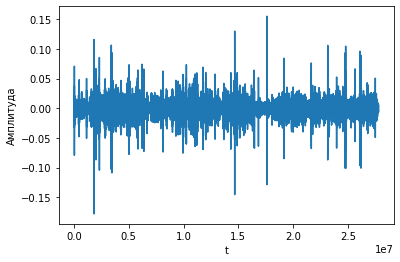

In [ ]:
plt.ylabel('Амплитуда')
plt.xlabel('t')
plt.plot(data)

In [ ]:
'''
def entropy(labels):
  entropies = []
  final = []
  vc = pd.Series(labels).value_counts(normalize=True, sort=False)
  for i in vc:
    entropies.append(i * np.log(i)/np.log(2))
  threshold = (max(entropy(data)) - min(entropy(data))) * 0.5
  for i in entropies: 
    if i < threshold:
      final.append(i)
  return final
  '''

In [ ]:
data

array([-0.00119019, -0.0022583 , -0.00219727, ...,  0.00418091,
        0.00311279,  0.00125122], dtype=float32)

In [ ]:
data.shape

(31479126,)

In [ ]:
# !apt install ffmpeg

In [ ]:
# hop length==number audio of frames between STFT columns. If unspecified, defaults win_length / 4.

def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # выход: [window_length, num_windows]

In [ ]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # разбиваем амплитуды на пересекающиеся фреймы [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)

    # получаем веса для Фурье, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # применяем преобразование Фурье
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

In [ ]:
# fmin == lowest frequency
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=10002):

   # оконное преобразование фурье 
    stft = get_STFT(amplitudes, window_length, hop_length)
    # возводим в квадрат mel частоты и лоагрифмируем 
    spectrogram = np.log(stft ** 2)
    # получаем из них спектральные коэффициенты с помощью косинусного дискретного преобразования 
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    return mel_spectrogram

In [ ]:
amplitudes, sample_rate = librosa.load('ES2006d.Array1-01.wav')
print(f"{len(amplitudes)} points, {len(amplitudes) / sample_rate} sec, sr {sample_rate}")

41184431 points, 1867.774648526077 sec, sr 22050


In [ ]:
# проверим на готовом методе получения спектограммы из библиотеке librosa
spect_library = librosa.feature.melspectrogram(amplitudes, sr=sample_rate)

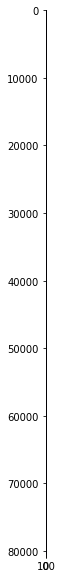

In [ ]:
plt.figure(figsize=[10, 10])
plt.imshow(spect_library.transpose())

In [8]:
# !pip3 install --upgrade speechrecognition

In [9]:
# !pip install ibm_watson

In [ ]:
import subprocess 
import os
command = 'ffmpeg -i ES2006d.Array1-01.wav -vn -ar 44100 -ac 2 -b:a 192k audio.mp3'
subprocess.call(command, shell=True)


0

In [ ]:
command = 'ffmpeg -i audio.mp3 -f segment -segment_time 360 -c copy %03d.mp3'
subprocess.call(command, shell=True)

0

## Google speech to text <a class="anchor" id="ch17"></a>

In [ ]:
!pip install SpeechRecognition

     |████████████████████████████████| 32.8MB 111kB/s 


In [ ]:
import speech_recognition as sr
r = sr.Recognizer()
audio = sr.AudioFile('/content/ES2006d.Array1-01.wav')
text_google = []
with audio as source:
    r.adjust_for_ambient_noise(source)
    audio = r.record(source)
try:
    print("Google Speech Recognition thinks you said " + r.recognize_google(audio))
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))

Could not request results from Google Speech Recognition service; recognition connection failed: [Errno 32] Broken pipe


In [ ]:
!pip install pydub

In [ ]:
import speech_recognition as sr

AUDIO_FILE = "/content/ES2006d.Array1-01.wav"
WIT_AI_KEY = "SVPUW2NGGISTKVCCZMUKH3LEJVJY5Q7I" 
r = sr.Recognizer()
with sr.AudioFile(AUDIO_FILE) as source:
    audio = r.record(source) # Wit.ai keys are 32-character uppercase alphanumeric strings
try:
    print("Wit.ai thinks you said " + r.recognize_wit(audio, key=WIT_AI_KEY))
except sr.UnknownValueError:
    print("Wit.ai could not understand audio")
except sr.RequestError as e:
    print("Could not request results from Wit.ai service; {0}".format(e))


Could not request results from Wit.ai service; recognition request failed: Bad Request


## wav2vec <a class="anchor" id="ch18"></a>

In [ ]:
import subprocess 
import os
command = 'ffmpeg -i /content/ES2009c.Array1-01.wav -vn -ar 44100 -ac 2 -b:a 192k audio.mp3'
subprocess.call(command, shell=True)
command = 'ffmpeg -i audio.mp3 -f segment -segment_time 10 -c copy %03d.mp3'
subprocess.call(command, shell=True)

0

In [ ]:
files = []
for filename in os.listdir('.'):
    if filename.endswith(".mp3") and filename !='audio.mp3':
        files.append(filename)
files.sort()

In [ ]:
!pip install -q transformers

In [ ]:
import librosa

#Importing Pytorch
import torch

#Importing Wav2Vec
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

In [ ]:
audio, rate = librosa.load('/content/000.mp3', sr = 16000)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:419: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input_values = tokenizer(audio, return_tensors = "pt").input_values

In [ ]:
len(input_values[0])

159887

In [ ]:
# Storing logits (non-normalized prediction values)

logits = model(input_values).logits

In [ ]:
prediction = torch.argmax(logits, dim = -1)
transcription = tokenizer.batch_decode(prediction)[0]


In [ ]:
files

['000.mp3',
 '001.mp3',
 '002.mp3',
 '003.mp3',
 '004.mp3',
 '005.mp3',
 '006.mp3',
 '007.mp3',
 '008.mp3',
 '009.mp3',
 '010.mp3',
 '011.mp3',
 '012.mp3',
 '013.mp3',
 '014.mp3',
 '015.mp3',
 '016.mp3',
 '017.mp3',
 '018.mp3',
 '019.mp3',
 '020.mp3',
 '021.mp3',
 '022.mp3',
 '023.mp3',
 '024.mp3',
 '025.mp3',
 '026.mp3',
 '027.mp3',
 '028.mp3',
 '029.mp3',
 '030.mp3',
 '031.mp3',
 '032.mp3',
 '033.mp3',
 '034.mp3',
 '035.mp3',
 '036.mp3',
 '037.mp3',
 '038.mp3',
 '039.mp3',
 '040.mp3',
 '041.mp3',
 '042.mp3',
 '043.mp3',
 '044.mp3',
 '045.mp3',
 '046.mp3',
 '047.mp3',
 '048.mp3',
 '049.mp3',
 '050.mp3',
 '051.mp3',
 '052.mp3',
 '053.mp3',
 '054.mp3',
 '055.mp3',
 '056.mp3',
 '057.mp3',
 '058.mp3',
 '059.mp3',
 '060.mp3',
 '061.mp3',
 '062.mp3',
 '063.mp3',
 '064.mp3',
 '065.mp3',
 '066.mp3',
 '067.mp3',
 '068.mp3',
 '069.mp3',
 '070.mp3',
 '071.mp3',
 '072.mp3',
 '073.mp3',
 '074.mp3',
 '075.mp3',
 '076.mp3',
 '077.mp3',
 '078.mp3',
 '079.mp3',
 '080.mp3',
 '081.mp3',
 '082.mp3',
 '08

In [ ]:
results_facebook = []
for filename in files:
        audio, rate = librosa.load(filename, sr = 16000)
        input_values = tokenizer(audio, return_tensors = "pt").input_values
        logits = model(input_values).logits
        prediction = torch.argmax(logits, dim = -1)
        transcription = tokenizer.batch_decode(prediction)[0]
        results_facebook.append(transcription.lower())

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [ ]:
results_facebook_ = []
for i in results_facebook:
  results_facebook_.append(i.lower())

In [ ]:
text_str_facebook = ' '.join(results_facebook_)

In [ ]:
text_str_facebook

"o o  angr me yo art selt an  rainas you o go all right mejuss howr parosir fool h right so on this meaning will be about the conceptual design tot as ma precisell conceptual design is sa just something important at we not do im ti scanava turningly abstract into slighting more concretein is meaning ideal we will come to some final decisions aover than it is for the prototat im right so an apoligise for the last meeting it was brought to my hension that i did not make the rules clear enough and so i will attempt to do so more accurately in paricular medi am there enough exulin watars good am so bsi ga worging to do is hassome presentat to get much at glast time im gaga throughyo i werotska firsis find mi ma i many old kolat what we know about im o iscussing lasting any possible directions and then we'll make some more decisions on a basinfirm up our idea how we want this romoo t look and work se perfect so without the further adea where alt go first to spikin ot o er sciding togoet it 

In [ ]:
wer_facebook = wer(text_str_facebook, transcript_speech)
print('WER facebook: {}'.format(wer_facebook))

WER facebook: 131.48404993065188


## IBM Watson <a class="anchor" id="ch19"></a>

In [10]:
# !pip install ibm_watson

In [ ]:
from ibm_watson import SpeechToTextV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [ ]:
apikey = 'wx9rd4_OMeYZpzOHBcfhDNXW5X6ECrfaU0u54fhwiY0M'
url = 'https://api.eu-gb.speech-to-text.watson.cloud.ibm.com/instances/5019271f-5147-4778-835d-8c1fac38fee6'

In [ ]:
authenticator = IAMAuthenticator(apikey)
stt = SpeechToTextV1(authenticator = authenticator)
stt.set_service_url(url)

In [ ]:
results_ibm = []
for filename in files:
    with open(filename, 'rb') as f:
        res = stt.recognize(audio=f, content_type='audio/mp3', model='en-AU_NarrowbandModel', continuous=True, \
                           inactivity_timeout=360).get_result()
        results_ibm.append(res)

In [ ]:
text = []
for file in results_ibm:
    for result in file['results']:
        text.append(result['alternatives'][0]['transcript'].rstrip())

In [ ]:
text_str = ' '.join(text)

In [ ]:
wer_ibm = wer(text_str, transcript_speech)
print('WER IBM: {}'.format(wer_ibm))

WER IBM: 752.6385224274406


## Метрики для распознавания речи <a class="anchor" id="ch20"></a>

In [11]:
# !pip install Levenshtein

In [ ]:
import Levenshtein as Lev
def wer(s1, s2): 
    b = set(s1.split() + s2.split()) 
    word2char = dict(zip(b, range(len(b))))
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]
    wer_lev = Lev.distance(''.join(w1), ''.join(w2)) 
    wer_inst = float(wer_lev)/len(s1.split()) * 100
    return wer_inst
def cer(s1, s2):
    s1, s2, = s1.replace(' ', ''), s2.replace(' ', '')
    cer_inst = float(Lev.distance(s1, s2)) / len(s1) * 100 
    return cer_inst

# Комбинация алгоритма распознавания речи и суммаризации <a class="anchor" id="ch21"></a>

In [ ]:
test_ext = open('/content/ES2009c.extsumm.txt', "r", errors = 'ignore')
human_ext = test_ext.read()
test_abs = open('/content/ES2009c.abssumm.txt', "r", errors = 'ignore')
human_abs = test_abs.read()

In [ ]:
text_str_facebook

''

In [ ]:
# частотный подход и wav2vec
final_sum_2_freq = summary_luhn(text_str_facebook)

In [ ]:
rouge = Rouge()
scores = rouge.get_scores(final_sum_2_freq, human_ext)
print('Luhn scores: {}'.format(scores))

Luhn scores: [{'rouge-1': {'f': 0.28158457933283115, 'p': 0.7315716272600834, 'r': 0.17434537620152468}, 'rouge-2': {'f': 0.12533475854345016, 'p': 0.32590529247910865, 'r': 0.07758620689655173}, 'rouge-l': {'f': 0.33093524735212015, 'p': 0.49595687331536387, 'r': 0.2483130904183536}}]


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
reference = preprocess_text_simple(human_ext)
candidate = preprocess_text_simple(final_sum_2_freq)
score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(score_together)
print(bleu_1)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.2726342139657395
0.005524861878453037


In [ ]:
text_str_facebook

"shdie oiicious visant witli  ma here are repli gis o o oweryo soyo o yes think us  befort managincin ah so and then no wewere close is meeting aand oft if meetet weal o  lat a lech god oo ma a why a anna can you a door a pristalta you don have for olliver i a one at tay gain agan again my l iwork e tas ou bet go an  walo an able to n to wa i can dell tha abat mer a it my be may be cenente candyof thork bad or it may be con you to wid what if necessary am but i disdaine an present withsom by set a da ad a small bagof scrapes i honpy people disasking atat there remark a trall yeu seigh havits and what they want to know my control um it's haw igatyon asked he ive just got a white page tisnt at on it im bis clit saying that use is jerally disli it at a beal of yot to say ma oe sai an e may ogantis comoka asaays open it or fees wic teaf there my controls i'm seventy five yo senta cap set of uses fine mustwrite te tross eyway nam i hip said afbusist would spend more money when i are aout to

In [ ]:
# XLNet
model_xlnet = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")
full_abs_fin = ''.join(model_xlnet(text_str_facebook))
print(full_abs_fin)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
rouge = Rouge()
scores = rouge.get_scores(full_abs_fin, human_abs)
print('xlnet + wav2vec scores: {}'.format(scores))

ValueError: ignored

In [ ]:
reference = preprocess_text_simple(human_abs)
candidate = preprocess_text_simple(full_abs_fin)
score_together = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(score_together)

0
